# Panorama Image Stitching

In [279]:
# Import libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils

In [280]:
# Common variables

testing_img1 = "train_images/Set4/1.jpg"
testing_img2 = "train_images/Set4/2.jpg"

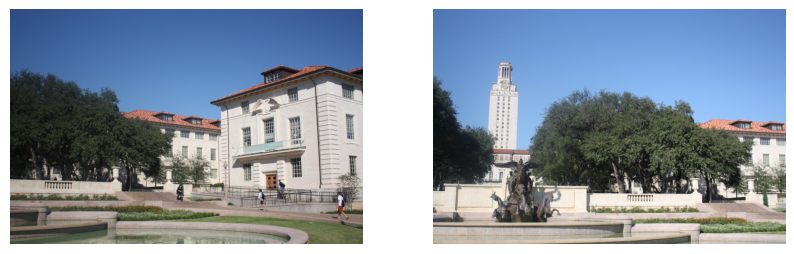

In [281]:
# Read in images for use throughout testing
img1 = cv2.cvtColor(cv2.imread(testing_img1), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(testing_img2), cv2.COLOR_BGR2RGB)

# Display both images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis("off")

plt.show()

#### Corner Detection and Feature Descriptors with SIFT

In [282]:
# Detect keypoints within the image for use in feature matching
# Also create descriptors for each keypoint

def detect_keypoints(img):
    # Use SIFT
    descriptor = cv2.xfeatures2d.SIFT_create()
        
    # Get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(img, None)
    
    return kps, features

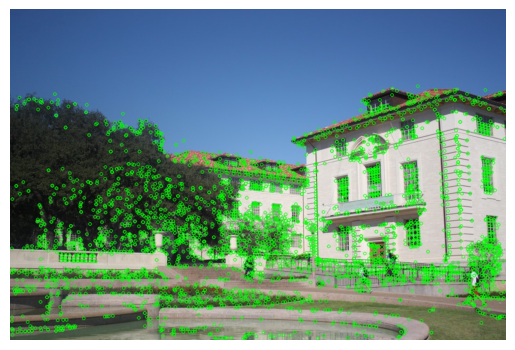

In [283]:
# Display image with marked keypoints

# Get keypoints and feature descriptors
kps, features = detect_keypoints(img1)

# Display image
plt.imshow(cv2.drawKeypoints(img1, kps, None, color=(0,255,0)))
plt.axis("off")
plt.show()

#### Feature Matching with KNN

In [284]:
# Calculate best feature matches between 2 sets of keypoints

def matchKeyPointsKNN(kps1, kps2, ratio):
    # Brute force match points based on euclidean distance
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Get the 2 closest potential feature matches for each keypoint
    matches = bf.knnMatch(kps1, kps2, 2)

    # Loop over the potential feature matches
    true_matches = []
    for m, n in matches:
        # True match if distance is within a certain ratio
        if m.distance < n.distance * ratio:
            true_matches.append(m)

    return true_matches

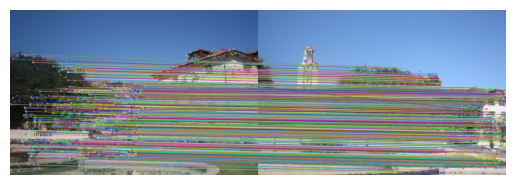

In [285]:
# Display feature matching

# Get keypoints
kps1, features1 = detect_keypoints(img1)
kps2, features2 = detect_keypoints(img2)

# Compute feature matching
matches = matchKeyPointsKNN(features1, features2, ratio=0.6)

# Draw lines to visualize feature matches
# matched = cv2.drawMatches(img1, kps1, img2, kps2, np.random.choice(matches, 100), None)
matched = cv2.drawMatches(img1, kps1, img2, kps2, matches, None)

# Display image
plt.imshow(matched)
plt.axis("off")
plt.show()

#### Homography Estimation with RANSAC

In [286]:
# Compute an estimation for the homography matrix using RANSAC

def compute_homography(kps1, kps2, features1, features2, matches, threshold):
    # Convert the keypoints to numpy arrays
    kps1 = np.float32([kp.pt for kp in kps1])
    kps2 = np.float32([kp.pt for kp in kps2])
    
    # Link corresponding keypoints between images: point correspondence
    kp1 = np.float32([kps1[m.queryIdx] for m in matches])
    kp2 = np.float32([kps2[m.trainIdx] for m in matches])
        
    # Use RANSAC to compute homography estimation
    (H, status) = cv2.findHomography(kp1, kp2, cv2.RANSAC, threshold)

    return H, status

In [287]:
# Get estimated homography matrix

H, status = compute_homography(kps1, kps2, features1, features2, matches, threshold=4)

# Display homography matrix
print(H)

[[ 7.64495755e-01  3.74533918e-02  4.46573886e+02]
 [-1.35817101e-01  9.11536309e-01  7.61975112e+01]
 [-2.11989569e-04 -3.24924794e-05  1.00000000e+00]]


#### Blend Images

In [288]:
# Complete the actual stitching of both images

def warp_and_blend(img1, img2, H):
    # Calculate height and width of resulting stitched image
    height = img1.shape[0] + img2.shape[0]
    width = img1.shape[1] + img2.shape[1]

    # Warp intial image based on homography matrix and overlay second image
    stitched_img = cv2.warpPerspective(img1, H, (width, height))
    stitched_img[0:img2.shape[0], 0:img2.shape[1]] = img2

    # Threshold image in order to determine main content of stitched image
    g = cv2.cvtColor(stitched_img, cv2.COLOR_BGR2GRAY)
    thresholded = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY)[1]

    # Find countours in image to identify relevant content in stitched image
    countoured = imutils.grab_contours(cv2.findContours(thresholded.copy(), 
                                                  cv2.RETR_EXTERNAL, 
                                                  cv2.CHAIN_APPROX_SIMPLE))

    # Calculate bounding box parameters for final stitched image
    max_contour = max(countoured, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(max_contour)

    # Crop the image to only the bounding box
    stitched_img = stitched_img[y:y + h, x:x + w]

    return stitched_img

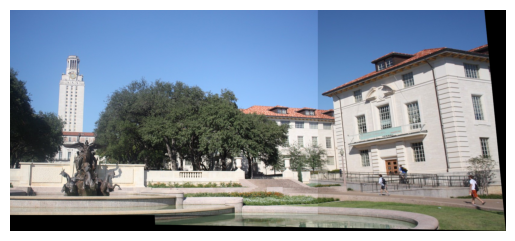

In [289]:
# Display final stitched image

# Get stitched image
stitched_img = warp_and_blend(img1, img2, H)

# Display image
plt.imshow(stitched_img)
plt.axis("off")
plt.show()